# Linear Regression

Implementação de Regressão Linear

Melhores resultados: 

|      | Regressão Linear |
|------|------------------|
| RMSE | 39215.75         |
| MAE  | 26945.61         |
| MAPE | 0.37             |

Testes
- power transformer
- scalers
- retirar variáveis com alta correlação 
- retirar alguns anos


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow.random import set_seed

sns.set_palette("Paired")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

# Constantes

In [3]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

N='NORTE'
NE="NORDESTE"
CO='CENTRO OESTE'
SE='SUDESTE'
S = 'SUL'

REGIOES = {
    'AC': N, 'AL': NE, 'AM' : N, 'AP' : N, 'BA' : NE, 'CE' : NE,
    'DF' : CO, 'ES' : SE, 'GO' : CO, 'MA' : NE,
    'MG' : SE, 'MS' : CO, 'MT' : CO, 'PA' : N, 'PB' : NE,
    'PE' : NE, 'PI' : NE, 'PR' : S, 'RJ' : SE,
    'RN' : NE, 'RO' : N, 'RR' : N, 'RS' : S,
    'SC' : S, 'SE' : NE, 'SP' : SE, 'TO' : N}

# Funções

In [4]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [5]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [6]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))

    g = sns.countplot(data=error, x='categoria', order=LABELS)
    
    plt.show()

In [7]:
def get_pred (y_test, y_pred):
    
    init = pd.to_datetime("072017", format='%m%Y')
    end = pd.to_datetime("122019", format='%m%Y')
    data = pd.date_range(start=init, end=end, freq='MS').date
    
    pred = pd.DataFrame(list(data) * 27, columns=['data']).sort_values('data')
    
    pred['estados'] = SIGLAS * 30
    
    pred['y_test'] =  y_test[len(y_test) % 27 :].values
    pred['y_pred'] = y_pred[len(y_pred) % 27 :]
    
    pred = pred.set_index('data')
    
    pred['regiao'] = pred['estados'].apply(get_regiao)
    
    return pred

In [8]:
def show_pred (pred, states=SIGLAS):
    
    for state in states:
        
        fig, ax = plt.subplots()

        pred[pred['estados'] == state].plot(y="y_pred", ax=ax, figsize=(12,6), color="coral", title=f"Previsão x Dado Real: {state}", ylabel="Consumo")
        pred[pred['estados'] == state].plot(y="y_test", linestyle=' ', marker="o", ax=ax)

    plt.show()

In [9]:
def get_regiao (x):
    return REGIOES[x]

In [10]:
def show_graphs (pred, reg):
    
    plt.figure(figsize=(14,6))
    
    
    plt.title("Visão regional")
    
    for state in reg:
        
        sns.scatterplot(pred[pred['estados'] == state]['y_test'], label=f"Dado real de {state}")
        sns.lineplot(pred[pred['estados'] == state]['y_pred'], label=f"Previsão e {state}")
        
    plt.ylabel="Consumo"
        
    plt.show()

In [11]:
def region_metrics (pred):

    for reg in pred['regiao'].unique():
        
        print (f"Metricas de {reg}:")
        print (f"RMSE: {mean_squared_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'], squared=False)}")
        print (f"MAPE: {mean_absolute_percentage_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'])}")
        print (f"MAE: {mean_absolute_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'])}")
        print ("-------------------------------\n")

In [12]:
def region_graphs (pred, reg):
    
    plt.figure(figsize=(18,6))
        
    plt.title(f"Visão regional: {reg}")
    
    pred=pred[pred['regiao'] == reg]
    
    plt.ylabel="Consumo"
    sns.scatterplot(pred, x=pred.index, y='y_test', hue="estados")
    sns.lineplot(pred, x=pred.index, y='y_pred', hue="estados")
    
        
    plt.show()

# Seed

In [13]:
SEED = 41

In [14]:
def set_seeds (SEED=41):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

In [15]:
set_seeds(SEED)

# Dados

In [16]:
def load_data():
    
    df = pd.read_csv(f"{PATH}df.csv")
    
    x  = df.copy()
    x = x.sort_values(["data", "estados"])
    x = x.drop(["consumo", 'data'], axis=1)

    y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]
    
    # processo de one-hot
    x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

    y = y['consumo']
    
    return x,y

# Sem normalização

In [17]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.9042171956961467
Scores obtidos:
RMSE: 55391.14904561992
MAE: 35148.64226804561
MAPE: 0.6043040236337529


# Standard Scaler

In [18]:
x,y = load_data()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.9042171951049084
Scores obtidos:
RMSE: 55391.14921657633
MAE: 35148.642315725585
MAPE: 0.604304023275496


# MinMax Scaler

In [21]:
x,y = load_data()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.9042171951049084
Scores obtidos:
RMSE: 55391.149216576334
MAE: 35148.64231572586
MAPE: 0.6043040232755041


# Power Transformer

In [20]:
x,y = load_data()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.8579867366398657
Scores obtidos:
RMSE: 67446.75410538058
MAE: 49073.620748753994
MAPE: 1.055163879940907


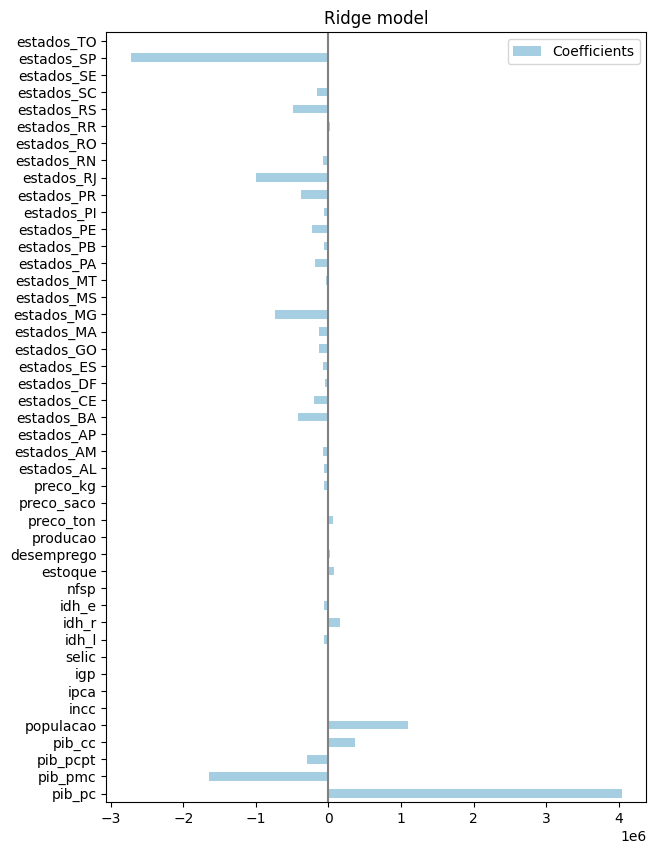

In [22]:
coefs = pd.DataFrame(
   regr.coef_,
   columns=['Coefficients'], index=x.columns
)

coefs.plot(kind='barh', figsize=(9, 10))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# Dropando variáveis com alta correlação

In [32]:
x,y = load_data()
DROP=['pib_pc', 'incc','igp', 'selic', 'idh_e', 'idh_l', 'nfsp','preco_saco', 'preco_ton', 'estoque']
x=x.drop(DROP, axis=1)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.9525886520535334
Scores obtidos:
RMSE: 38970.65917062515
MAE: 26435.65453576784
MAPE: 0.3237008399620483


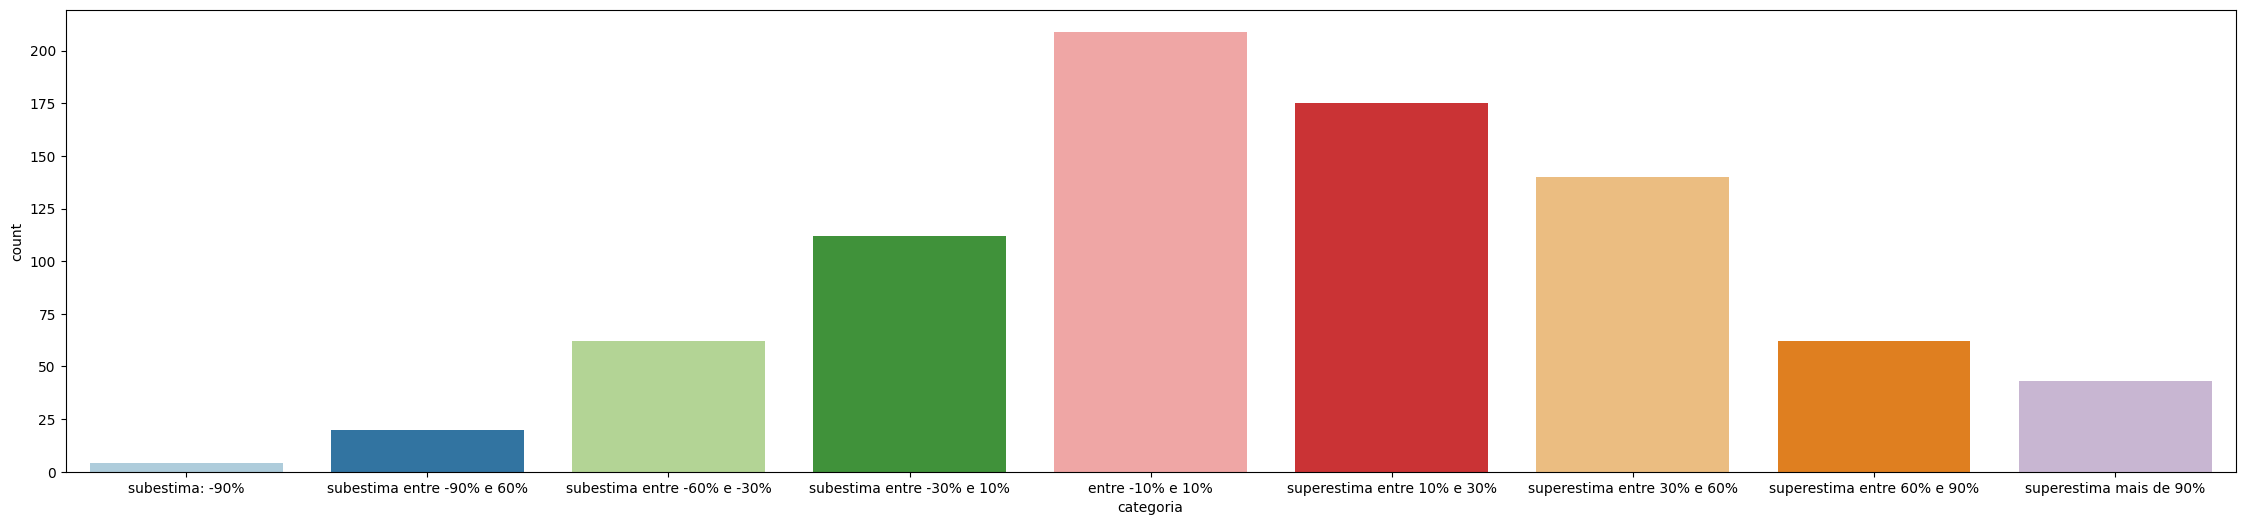

In [34]:
show_delta(np.array(y_test), y_pred.flatten())

## Gráficos

In [26]:
pred = get_pred(y_test, y_pred)

<AxesSubplot: xlabel='data'>

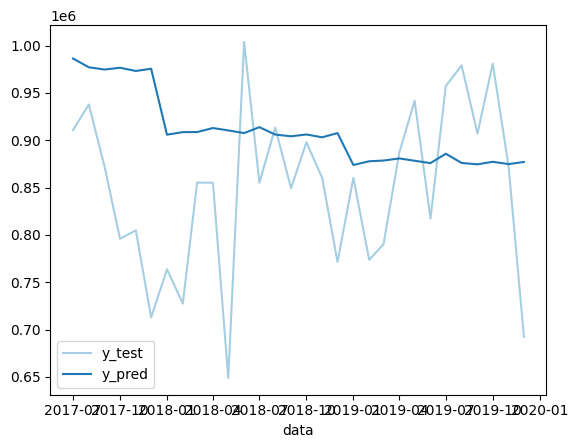

In [44]:
x=pred[pred["estados"] == "SP"].copy()
x[["y_test","y_pred"]].plot()

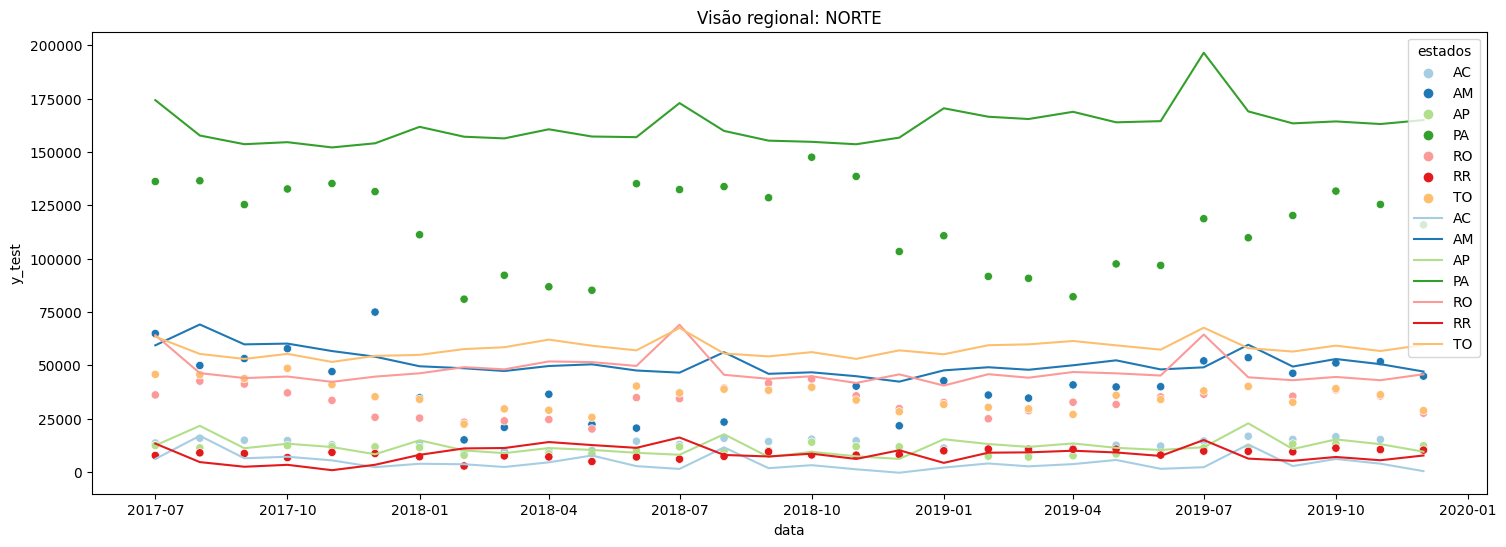

In [27]:
region_graphs(pred, 'NORTE')

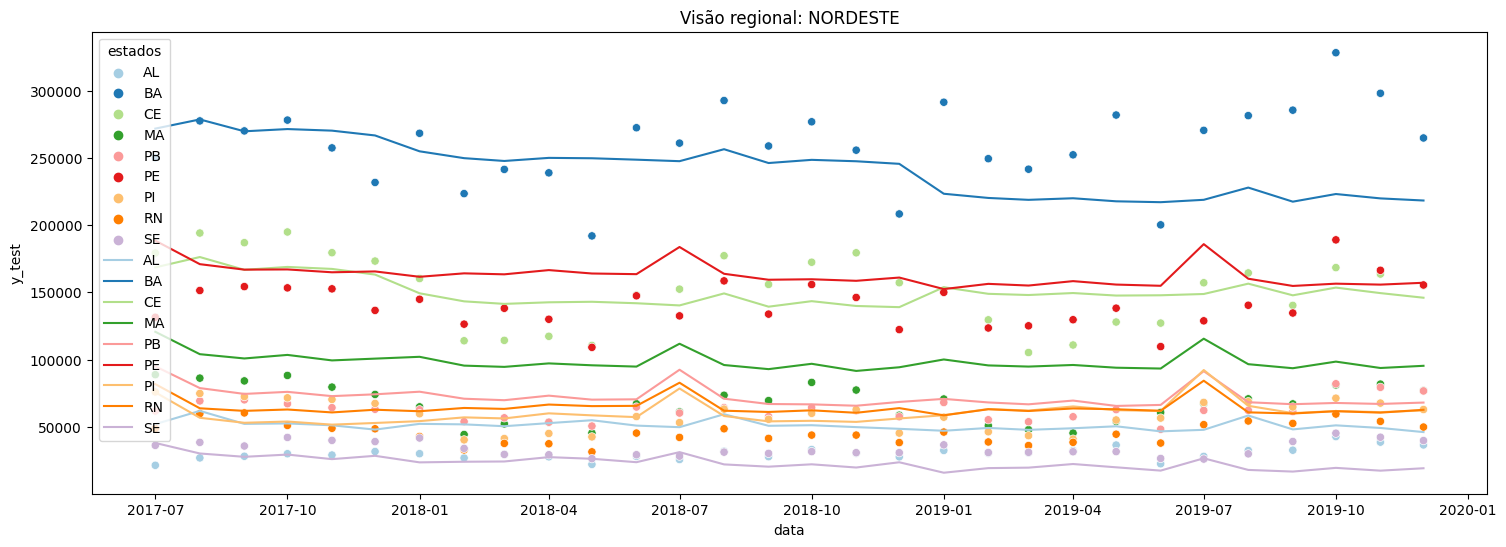

In [42]:
region_graphs(pred, 'NORDESTE')

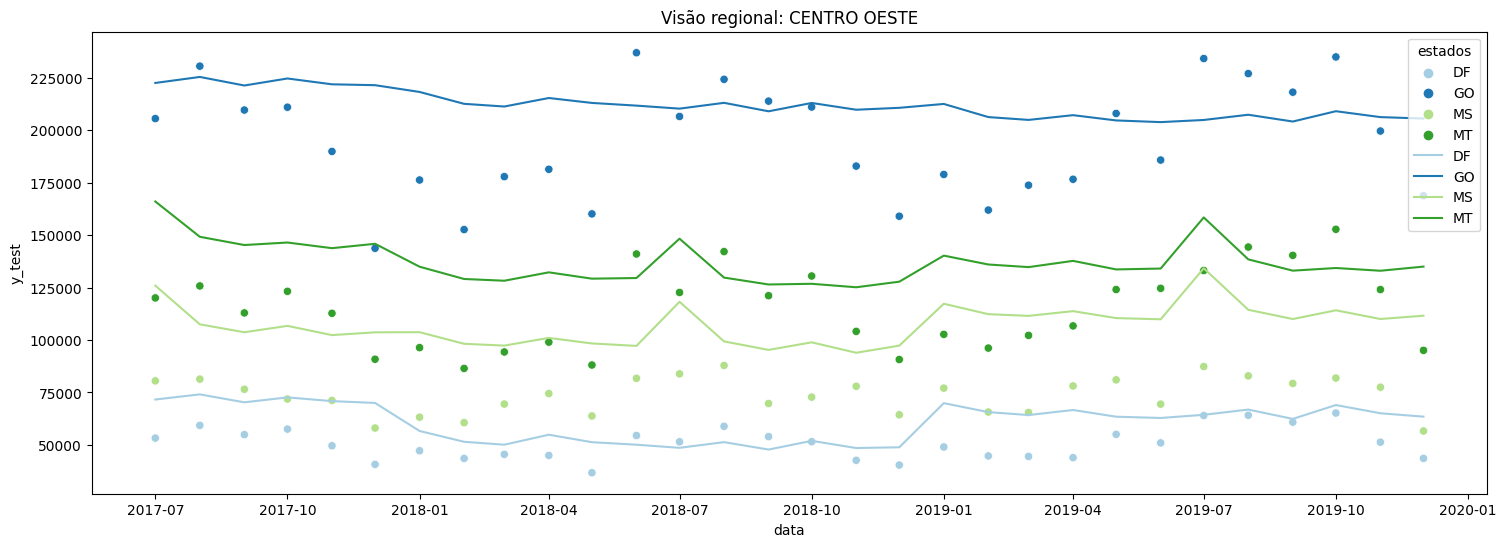

In [28]:
region_graphs(pred, 'CENTRO OESTE')

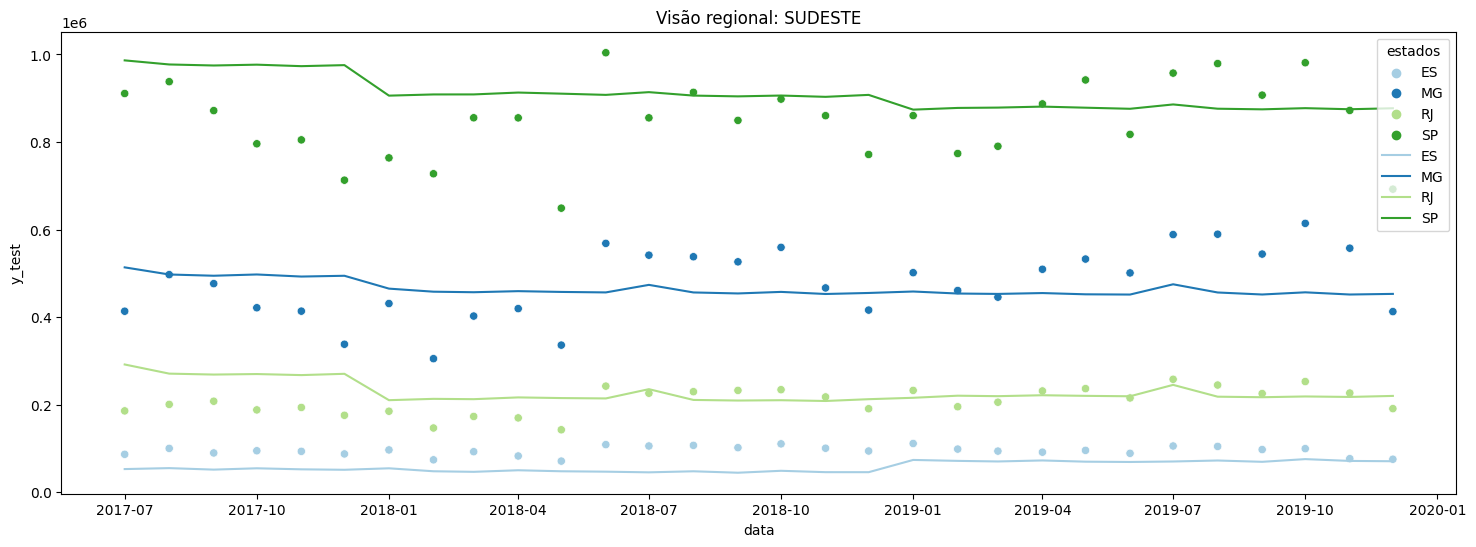

In [29]:
region_graphs(pred, 'SUDESTE')

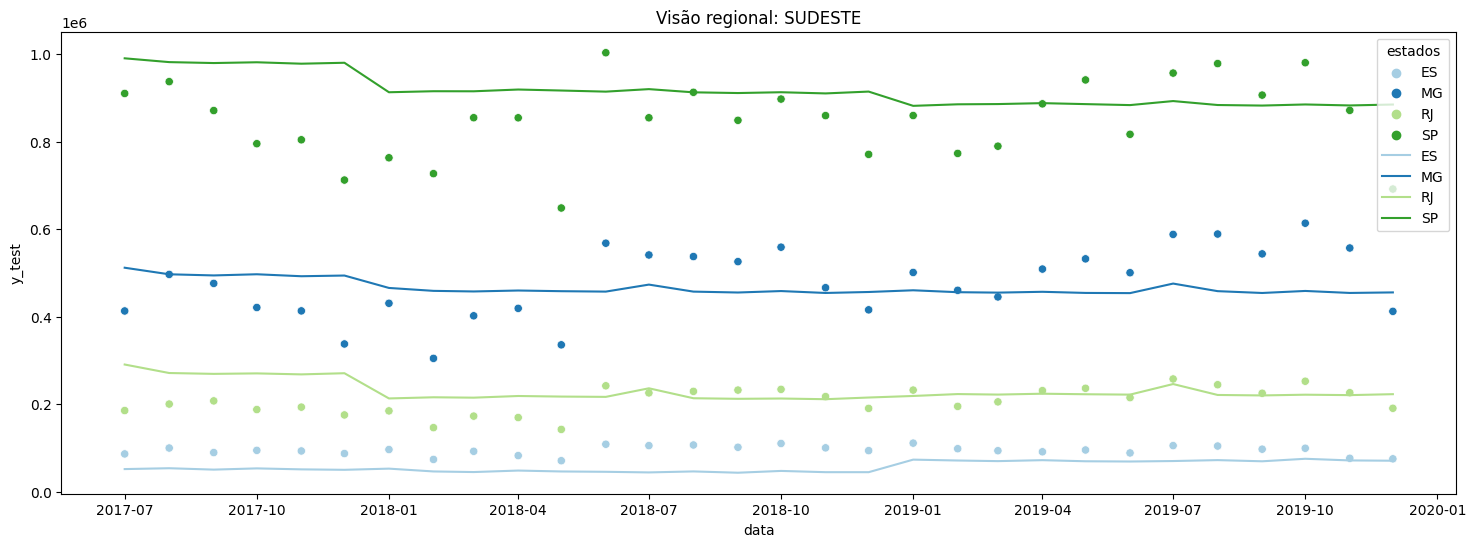

In [44]:
region_graphs(pred, 'SUDESTE')

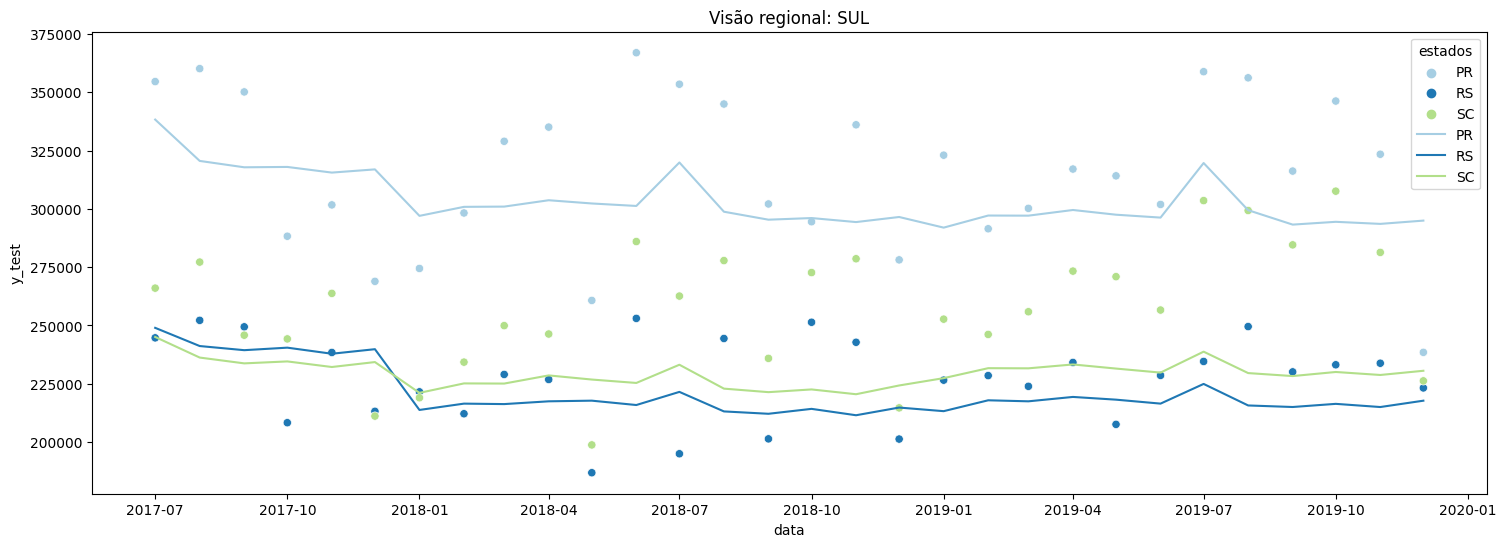

In [45]:
region_graphs(pred, 'SUL')

# Teste com dados só a partir de 2009

In [30]:
x,y = load_data()
DROP=['pib_pc', 'incc','igp', 'selic', 'idh_e', 'idh_l', 'nfsp','preco_saco', 'preco_ton', 'estoque']
x=x.drop(DROP, axis=1)
x = x.iloc[6*27*12:]
y = y.iloc[6*27*12:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.895967537850812
Scores obtidos:
RMSE: 59210.91355685945
MAE: 33672.04041893847
MAPE: 0.27627773641885534


In [45]:
x,y = load_data()
x = x.iloc[6*27*12:]
y = y.iloc[6*27*12:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.9085679739417918
Scores obtidos:
RMSE: 55509.39513162348
MAE: 32442.266811000773
MAPE: 0.3738210491457444


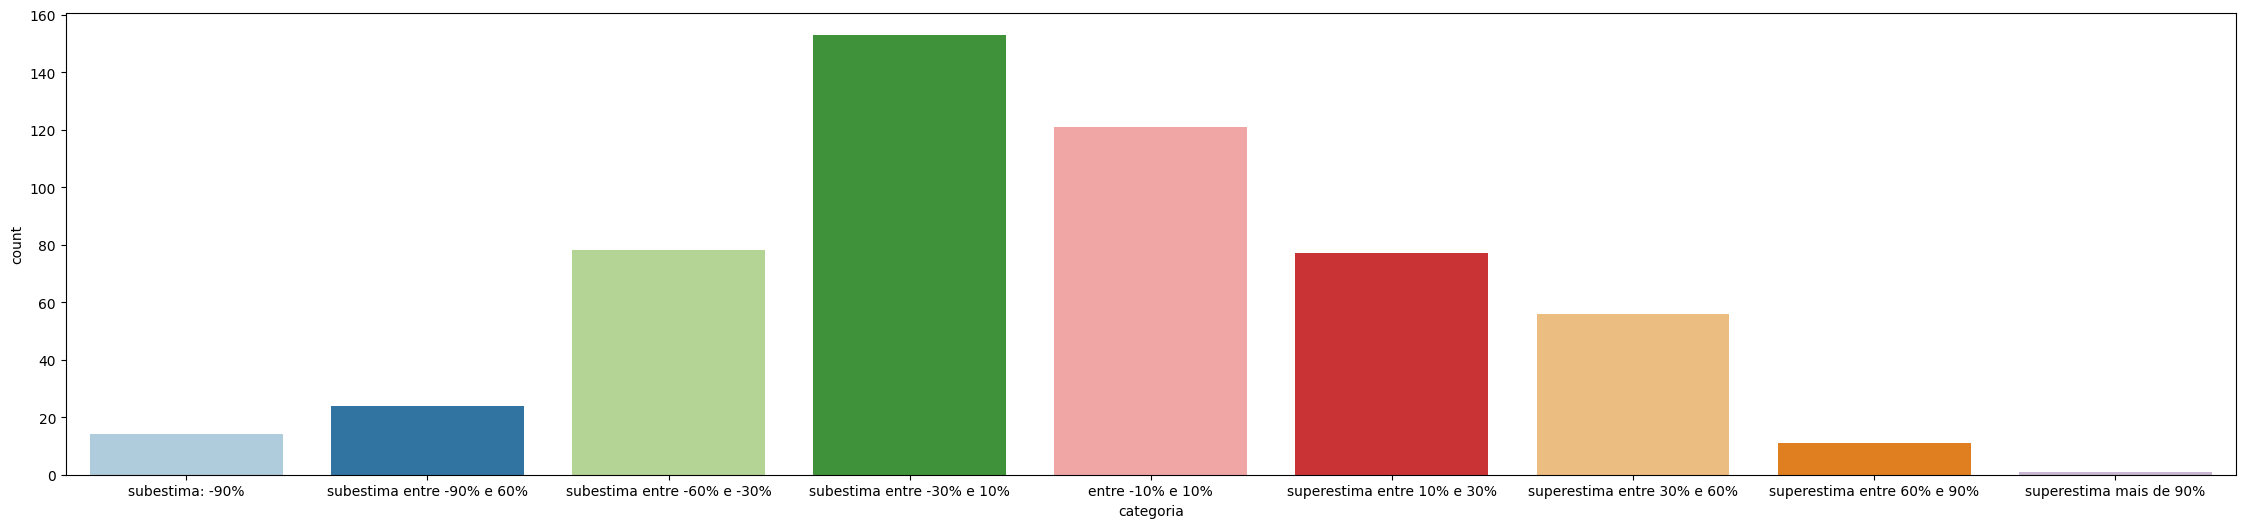

In [31]:
show_delta(np.array(y_test), y_pred.flatten())